In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *

In [14]:
def test_load_station_year(root):
    df = load_station_year(root, "KBOX", 2016)
    display(df)
    
def test_day_info():
    day_info = get_day_info("KBOX", 2016)
    display(day_info)

root = '../data'
test_load_station_year(root)
test_day_info()

Loading ../data/scan_level/KBOX-2016.csv


,station,lat,lon,solar_elevation,density,density_precip,traffic_rate,traffic_rate_precip,u,v,speed,direction,percent_rain,rmse
date,,,,,,,,,,,,,,
2016-12-01 00:03:12+00:00,KBOX,41.95583,-71.1375,-30.7850,1.8951,6128.0522,90.3063,294037.1971,-6.4099,8.4324,13.2367,322.7597,0.5931,8.9746
2016-12-01 00:09:01+00:00,KBOX,41.95583,-71.1375,-31.8656,1.5697,6285.1384,77.9268,301196.8119,-8.8222,1.4183,13.7899,279.1332,0.6273,8.5871
2016-12-01 00:14:52+00:00,KBOX,41.95583,-71.1375,-32.9530,1.0759,6483.9055,48.3805,312639.1989,-3.8236,5.2976,12.4914,324.1799,0.6712,6.5839
2016-12-01 00:20:41+00:00,KBOX,41.95583,-71.1375,-34.0345,0.9854,6356.3596,40.7778,306876.1506,-2.5783,5.9231,11.4952,336.4765,0.7170,5.1146
2016-12-01 00:26:30+00:00,KBOX,41.95583,-71.1375,-35.1159,1.3874,6233.1429,52.7665,303658.8732,-2.7831,6.0545,10.5644,335.3129,0.7486,4.9479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:42:47+00:00,KBOX,41.95583,-71.1375,13.4903,8.7774,0.2242,1078.4337,20.1512,2.1898,33.8813,34.1290,3.6980,0.0329,15.6509
2016-12-31 20:12:00+00:00,KBOX,41.95583,-71.1375,9.7395,9.2307,0.6596,1188.7351,73.3081,-1.5150,35.0527,35.7725,357.5251,0.0191,15.9234
2016-12-31 20:41:14+00:00,KBOX,41.95583,-71.1375,5.6256,11.5546,1.5801,1513.6531,165.0603,-0.8329,36.0919,36.3890,358.6779,0.0213,15.9765


,sunrise,sunset,transit,date,next_sunrise
2016-01-01 00:00:00+00:00,2016-01-01 12:12:26.480490752+00:00,2016-01-01 21:23:36.614387200+00:00,2016-01-01 16:47:57.305959680+00:00,2016-01-01,2016-01-02 12:12:31.958917632+00:00
2016-01-02 00:00:00+00:00,2016-01-02 12:12:31.958917632+00:00,2016-01-02 21:24:28.291636736+00:00,2016-01-02 16:48:25.490753024+00:00,2016-01-02,2016-01-03 12:12:35.102720768+00:00
2016-01-03 00:00:00+00:00,2016-01-03 12:12:35.102720768+00:00,2016-01-03 21:25:21.645841920+00:00,2016-01-03 16:48:53.349678080+00:00,2016-01-03,2016-01-04 12:12:35.905754112+00:00
2016-01-04 00:00:00+00:00,2016-01-04 12:12:35.905754112+00:00,2016-01-04 21:26:16.621244416+00:00,2016-01-04 16:49:20.852032256+00:00,2016-01-04,2016-01-05 12:12:34.363850496+00:00
2016-01-05 00:00:00+00:00,2016-01-05 12:12:34.363850496+00:00,2016-01-05 21:27:13.160422912+00:00,2016-01-05 16:49:47.967257344+00:00,2016-01-05,2016-01-06 12:12:30.474694656+00:00
...,...,...,...,...,...
2016-12-27 00:00:00+00:00,2016-12-27 12:11:37.342236160+00:00,2016-12-27 21:20:17.219565824+00:00,2016-12-27 16:45:54.733510400+00:00,2016-12-27,2016-12-28 12:11:52.784586240+00:00
2016-12-28 00:00:00+00:00,2016-12-28 12:11:52.784586240+00:00,2016-12-28 21:21:01.377882624+00:00,2016-12-28 16:46:24.131821312+00:00,2016-12-28,2016-12-29 12:12:05.932393472+00:00
2016-12-29 00:00:00+00:00,2016-12-29 12:12:05.932393472+00:00,2016-12-29 21:21:47.410730752+00:00,2016-12-29 16:46:53.322018048+00:00,2016-12-29,2016-12-30 12:12:16.765108224+00:00
2016-12-30 00:00:00+00:00,2016-12-30 12:12:16.765108224+00:00,2016-12-30 21:22:35.264818688+00:00,2016-12-30 16:47:22.267416576+00:00,2016-12-30,2016-12-31 12:12:25.264386816+00:00


,station,lat,lon,date,period,period_length,percent_missing,percent_filled,density_hours,density_hours_precip,traffic,traffic_precip,u,v,direction,speed,percent_rain
0,KBOX,41.9558,-71.1375,2017-01-01,day,9.19578,0.000000,0.027273,101.1440,7.067810,8437.29,366.6360,15.92190,-11.06830,114.715,23.2201,0.036834
1,KBOX,41.9558,-71.1375,2017-01-02,day,9.20944,0.000000,0.000000,148.0520,2101.310000,12529.50,71561.3000,-3.01384,8.38700,277.532,23.5053,0.095357
2,KBOX,41.9558,-71.1375,2017-01-03,day,9.22421,0.000000,0.000000,1260.0700,13508.300000,63293.20,703280.0000,-12.64430,2.56858,281.294,13.9725,0.539314
3,KBOX,41.9558,-71.1375,2017-01-04,day,9.24007,0.000000,0.000000,127.1070,239.067000,8559.61,15325.0000,6.91778,7.12025,120.285,18.7167,0.074316
4,KBOX,41.9558,-71.1375,2017-01-05,day,9.25700,0.000000,0.000000,96.5570,0.840142,10976.00,83.9120,13.00010,-3.95793,150.113,31.5906,0.009215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,KBOX,41.9558,-71.1375,2017-12-27,night,14.86180,0.000000,0.000000,51.3665,0.563608,5979.36,53.9240,1.10483,6.89739,225.645,32.2676,0.012992
726,KBOX,41.9558,-71.1375,2017-12-28,night,14.85350,0.000000,0.000000,48.1144,12.733000,5032.67,621.2020,1.28692,0.68629,222.819,29.1735,0.009453
727,KBOX,41.9558,-71.1375,2017-12-29,night,14.84400,0.000000,0.000000,41.0868,0.790925,4740.85,48.6037,1.61297,8.55208,206.472,32.1588,0.003249
728,KBOX,41.9558,-71.1375,2017-12-30,night,14.83330,0.000000,0.258427,44.7178,1147.660000,3401.32,38750.4000,7.31940,-6.46641,126.432,21.5364,0.206796


/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 41.9558 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == -71.1375 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 41.9558 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 41.9558 results in singular transformations; automatically expandin

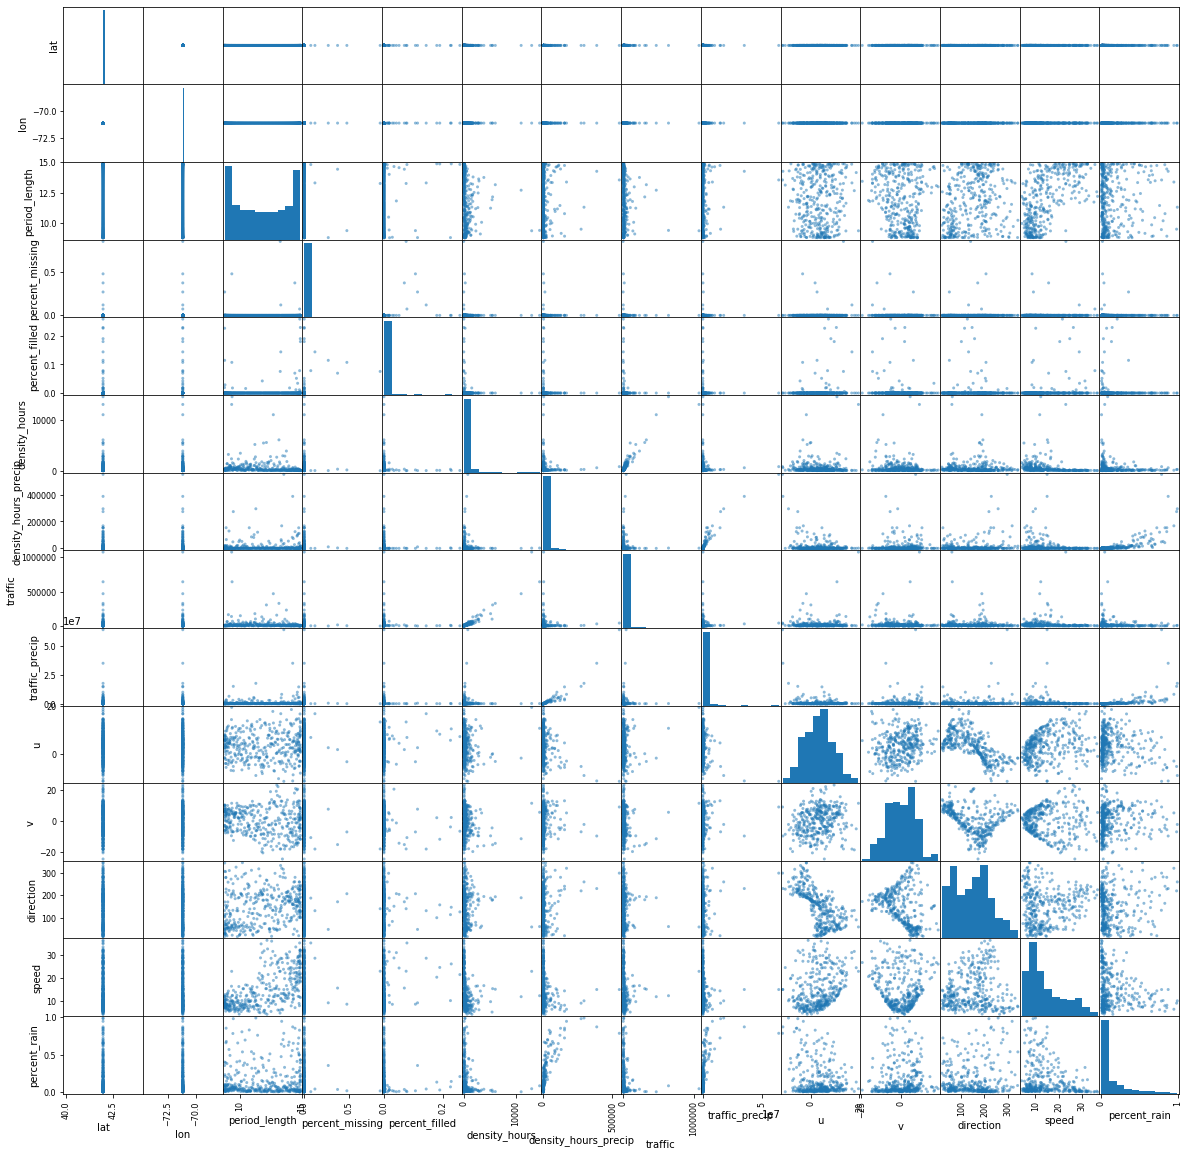

In [25]:
df = pd.read_csv('../data/daily/KBOX_2017.csv')
display(df)
pd.set_option('display.max_rows', 500)

night = df[df['period']=='night']
pd.plotting.scatter_matrix(night, figsize=(20,20))
plt.show()

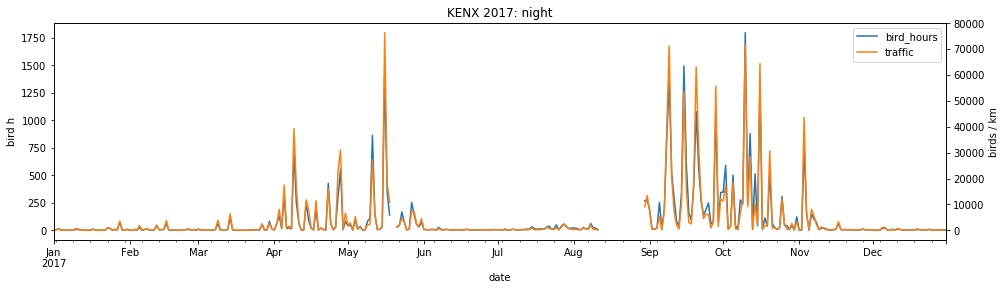

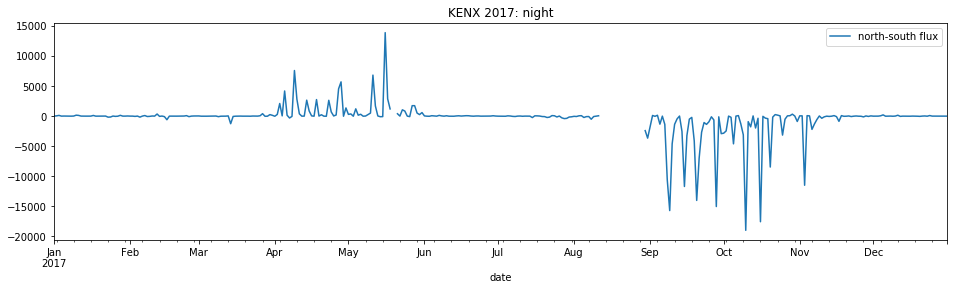

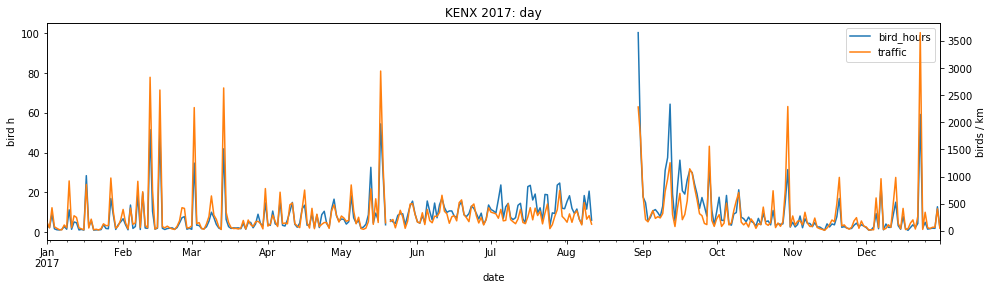

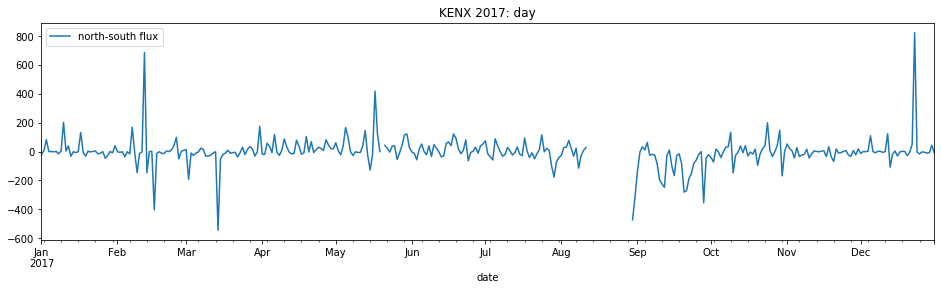

In [16]:
station = 'KENX'
year = 2017
root = '../data'

file = f'{root}/daily/{station}_{year}.csv'

df = pd.read_csv(file)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

bird_rcs = 11


for period in ['night', 'day']:
    plt.figure(figsize=(16,4))

    rows = df[df['period']==period]
    plt.title(f'{station} {year}: {period}')
    avg_speed = wtd_mean(rows['density_hours'], rows['speed'])

    bird_hours = rows['density_hours'] / bird_rcs
    bird_hours.name = 'bird_hours'
    ax = bird_hours.plot()
    plt.ylabel('bird h')

    (rows['traffic'] / bird_rcs).plot(secondary_y=True)
    plt.ylabel('birds / km')
    
    lines = ax.get_lines() + ax.right_ax.get_lines()
    ax.legend(lines, [l.get_label() for l in lines], loc='upper right')
    plt.show()
    
    
    plt.figure(figsize=(16,4))
    plt.title(f'{station} {year}: {period}')
    flux = (rows['v'] * bird_hours)
    flux.name = 'north-south flux'
    flux.plot()
    plt.legend()
    plt.show()

In [18]:
print(avg_speed)

9.315375066825503


In [5]:
files = ['../data/daily/KBOX-2017-daily.csv', '../data/daily/KENX-2018-daily.csv']

def read_files():
    for file in files:
        yield pd.read_csv(file)

df = pd.concat(read_files())
df = df[df['percent_missing'] <= 0.2]
df = df.pivot(index=['date', 'period'], columns='station', values=['density_hours', 'u', 'v', 'percent_rain'])
display(df)

density_hours                  u                    v  \
station                    KBOX     KENX      KBOX      KENX       KBOX   
date       period                                                         
2017-01-01 day         101.1440      NaN  15.92190       NaN -11.068300   
           night        83.0703      NaN  -3.11868       NaN   0.794045   
2017-01-02 day         148.0520      NaN  -3.01384       NaN   8.387000   
           night        27.3788      NaN  -4.97029       NaN   4.612700   
2017-01-03 day        1260.0700      NaN -12.64430       NaN   2.568580   
...                         ...      ...       ...       ...        ...   
2018-02-26 night            NaN  24.0309       NaN   6.73118        NaN   
2018-02-27 day              NaN  32.2086       NaN   5.00899        NaN   
           night            NaN  88.8576       NaN   9.19086        NaN   
2018-02-28 day              NaN  65.3157       NaN   5.42678        NaN   
           night            NaN  11.4196       NaN  11.14020        NaN   

                           percent_rain            
station               KENX         KBOX      KENX  
date       period                                  
2017-01-01 day         NaN     0.036834       NaN  
           night       NaN     0.000628       NaN  
2017-01-02 day         NaN     0.095357       NaN  
           night       NaN     0.497687       NaN  
2017-01-03 day         NaN     0.539314       NaN  
...                    ...          ...       ...  
2018-02-26 night  -4.45887          NaN  0.035327  
2018-02-27 day    -1.53169          NaN  0.027151  
           night   7.55943          NaN  0.037248  
2018-02-28 day     4.82396          NaN  0.121131  
           night   1.77221          NaN  0.624869  

[830 rows x 8 columns]

In [8]:
files = ['../data/5min/KBOX-2017-5min.csv', '../data/5min/KENX-2017-5min.csv']

def read_files():
    for file in files:
        yield pd.read_csv(file)

df = pd.concat(read_files())
        
df = df.pivot(index=['date'], columns='station', values=['density', 'traffic_rate', 'u', 'v', 'percent_rain'])
display(df)

density         traffic_rate                 u           \
station                 KBOX    KENX         KBOX     KENX     KBOX     KENX   
date                                                                           
2017-01-01 00:00:00Z  1.3157  0.5401     154.8747  39.8124  18.5754  16.0728   
2017-01-01 00:05:00Z  1.5169  0.5287     179.0008  39.4441  18.5462  16.4730   
2017-01-01 00:10:00Z  1.8596  0.5077     216.9888  39.1686  17.9982  17.6909   
2017-01-01 00:15:00Z  1.1582  0.7025     125.5023  49.5548  17.4696  15.9043   
2017-01-01 00:20:00Z  1.0969  0.5414     120.9572  41.1745  19.3924  18.0386   
...                      ...     ...          ...      ...      ...      ...   
2017-12-31 23:40:00Z     NaN     NaN          NaN      NaN      NaN      NaN   
2017-12-31 23:45:00Z     NaN     NaN          NaN      NaN      NaN      NaN   
2017-12-31 23:50:00Z     NaN     NaN          NaN      NaN      NaN      NaN   
2017-12-31 23:55:00Z     NaN     NaN          NaN      NaN      NaN      NaN   
2018-01-01 00:00:00Z     NaN     NaN          NaN      NaN      NaN      NaN   

                            v          percent_rain          
station                  KBOX     KENX         KBOX    KENX  
date                                                         
2017-01-01 00:00:00Z  26.0691  11.2130       0.0946  0.9469  
2017-01-01 00:05:00Z  26.1980  11.1626       0.0943  0.9444  
2017-01-01 00:10:00Z  25.8611  10.9264       0.0995  0.9342  
2017-01-01 00:15:00Z  23.5589  10.2959       0.1178  0.9162  
2017-01-01 00:20:00Z  22.8089  10.1372       0.1275  0.8964  
...                       ...      ...          ...     ...  
2017-12-31 23:40:00Z      NaN      NaN          NaN     NaN  
2017-12-31 23:45:00Z      NaN      NaN          NaN     NaN  
2017-12-31 23:50:00Z      NaN      NaN          NaN     NaN  
2017-12-31 23:55:00Z      NaN      NaN          NaN     NaN  
2018-01-01 00:00:00Z      NaN      NaN          NaN     NaN  

[105121 rows x 10 columns]

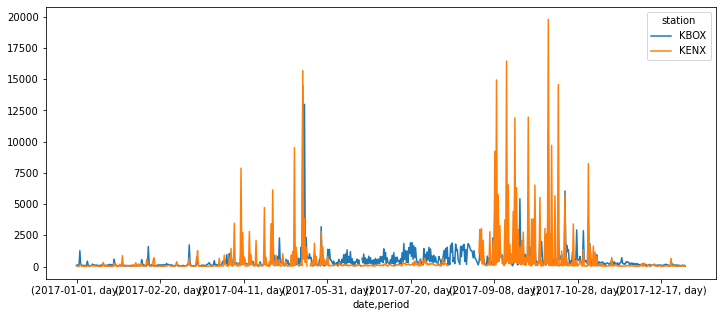

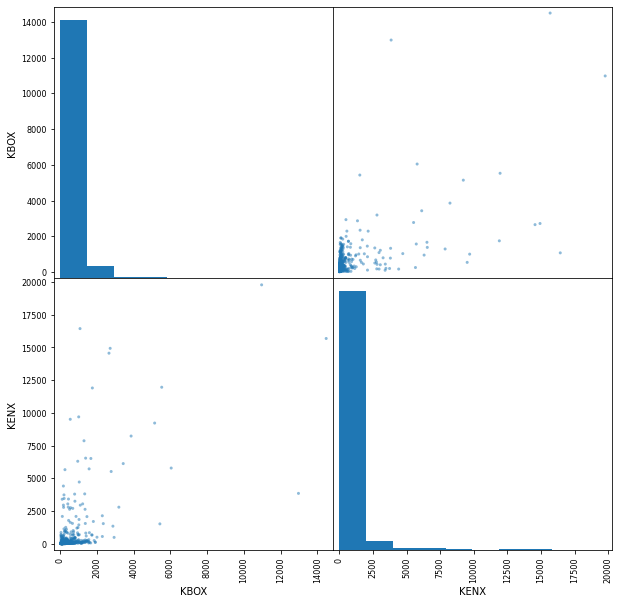

In [40]:
df.plot(figsize=(12,5))
plt.show()
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.show()

In [39]:
df

station                 KBOX      KENX
date       period                     
2017-01-01 day      101.1440   36.4657
           night     83.0703   21.3405
2017-01-02 day      148.0520   25.2090
           night     27.3788   55.6426
2017-01-03 day     1260.0700   99.3291
...                      ...       ...
2017-12-29 night     41.0868   47.6846
2017-12-30 day       56.3786  140.2610
           night     44.7177   40.6476
2017-12-31 day      103.0570   24.9643
           night     28.8986   45.6034

[730 rows x 2 columns]